In [257]:
!pip list | grep torch

torch                                    2.9.0+cu126
torch-geometric                          2.7.0
torchao                                  0.10.0
torchaudio                               2.9.0+cu126
torchdata                                0.11.0
torchsummary                             1.5.1
torchtune                                0.6.1
torchvision                              0.24.0+cu126


In [258]:
!pip install torch_geometric

In [259]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

In [260]:
print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.9.0+cu126; Torch-cuda version: 12.6; Torch Geometric version: 2.7.0.


In [261]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [262]:
"""
    • Acousticness - [float] whether the track is acoustic (0 to 1)
    • Danceability - [float] describes how suitable a track is for dancing (0 to 1)
    • Energy - [float] a perceptual measure of intensity and activity (0 to 1)
    • Instrumentalness - [float] Predicts whether a track contains no vocals (0 to 1)
    • Key - [integer] The key the track is in (-1 to 11)
    • Liveness - [float] Detects the presence of an audience in the recording (0 to 1)
    • Loudness - [float] The overall loudness of a track in decibels (dB). (-60 to 0 dB)
    • Mode - [integer] indicates the modality (major/1 or minor/0) of a track (1 or 0)
    • Speechiness - [float] detects the presence of spoken words in a track (0 to 1)
    • Tempo - [float] the overall estimated tempo of a track in beats/minute (~50 to ~200 BPM)
    • Valence - [float] the musical positiveness conveyed by a track (0 to 1)
"""

PROJ_DIR="/content/drive/MyDrive/CS782/Project"
os.chdir(PROJ_DIR)

# Global Shared feature store for all tracks.
X_DB = {}
X_PATH = Data_Path('features')


def load_X_DB():
    if X_DB:
        return X_DB

    for file_name in tqdm(os.listdir(X_PATH)):
        with open(join(X_PATH, file_name)) as json_file:
            json_data = json.load(json_file)
            for track_feature in json_data['content']:
                id = "spotify:track:" + track_feature['href'].split('/')[-1]
                X_DB[id] = np.array( [
                    track_feature["acousticness"],
                    track_feature["danceability"],
                    track_feature["energy"],
                    track_feature["instrumentalness"],
                    track_feature["key"],
                    track_feature["liveness"],
                    track_feature["loudness"],
                    track_feature["mode"],
                    track_feature["speechiness"],
                    track_feature["tempo"],
                    track_feature["valence"],
                ],
                dtype=float,
            )

    return X_DB

def get_track_features(track_uri):
    """ Retrieve the feature vector for a given track URI. """
    if not X_DB:
        load_X_DB()

    track_features = X_DB.get(track_uri)
    if track_features is None or np.isnan(track_features).any():
      return np.zeros(11, dtype=float)  # Not random
        # rng = np.random.default_rng()
        # track_features = np.array(
            # [
                # rng.uniform(0.0, 1.0),  # acousticness
                # rng.uniform(0.0, 1.0),  # danceability
                # rng.uniform(0.0, 1.0),  # energy
                # rng.uniform(0.0, 1.0),  # instrumentalness
                # float(rng.choice([-1] + list(range(12)))),  # key
                # rng.uniform(0.0, 1.0),  # liveness
                # rng.uniform(-60.0, 0.0),  # loudness (dB)
                # float(rng.integers(0, 2)),  # mode (0/1)
                # rng.uniform(0.0, 1.0),  # speechiness
                # rng.uniform(50.0, 200.0),  # tempo (BPM)
                # rng.uniform(0.0, 1.0),  # valence
            # ],
            # dtype=float,
        # )
        # print(f"Missing {track_uri}: Random features: {track_features}")
    return track_features


In [263]:
"""
  Simple class for a track, containing its attributes:
    1. URI (a unique id)
    2. Parent playlist
    3. Audio features
"""
class Track:

  def __init__(self, track_dict, playlist, features):
    self.uri = track_dict["track_uri"]
    self.playlist = playlist
    self.x = features

  def __str__(self):
    return f"Track {self.uri} in playlist {self.playlist}."

  def __repr__(self):
    return f"Track {self.uri}"


"""
  Simple class for a playlist, containing its attributes:
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. Playlist Features
"""
class Playlist:
  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data['tracks']

    self.tracks = {}
    self.x = []

  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""
    tracks_list = self.data
    playlist_features = []
    # self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    for t in tracks_list:
      track_features = get_track_features(t['track_uri'])
      self.tracks[t["track_uri"]] = Track(t, self.name, track_features)
      playlist_features.append(track_features)

    weights = np.linspace(1.0, 0.3, num=len(playlist_features))  # decay over position
    weights = weights / weights.sum()
    self.x = np.average(playlist_features, axis=0, weights=weights)
    # self.x = np.mean(playlist_features, axis=0)


  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."

  def __repr__(self):
    return f"Playlist {self.name}"




"""
  Simple class for a JSON file, containing its attributes:
    1. File Name
    2. Index to begin numbering playlists at
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
"""
class JSONFile:
  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."

  def __repr__(self):
    return self.file_name

In [264]:
os.chdir(PROJ_DIR)
DATA_DIR=Data_Path('dataset')

N_FILES_TO_USE = 50

file_names = sorted(os.listdir(DATA_DIR))
file_names_to_use = file_names[:N_FILES_TO_USE]
n_playlists = 0

JSONs = []

for file_name in tqdm(file_names_to_use, desc='Files Processed: ', unit='files', total=len(file_names_to_use)):
  json_file =  JSONFile(DATA_DIR, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)



Files Processed:   0%|          | 0/50 [00:00<?, ?files/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [265]:
playlist_data = {}
playlists = {}
tracks = {}

for json_file in tqdm(JSONs):
  playlists = playlists | {p.name: p.x for p in json_file.playlists.values()}
  tracks = tracks | {track.uri: track.x for playlist in json_file.playlists.values() for track in list (playlist.tracks.values())}
  playlist_data = playlist_data | json_file.playlists



  0%|          | 0/50 [00:00<?, ?it/s]

In [266]:

G = nx.Graph()

# Simply build a list of all playlist nodes
playlistNodes = []
for p in tqdm(playlists.keys()):
  playlistNodes.append( (p, {"node_type" : "playlist"}) )
G.add_nodes_from(playlistNodes)


# Simply build a list of all track nodes
trackNodes = []
for t in tqdm(tracks.keys()):
  trackNodes.append( (t, {"node_type" : "track"}) )
G.add_nodes_from(trackNodes)

# adding edges
edge_list = []
for p_name, playlist in tqdm(playlist_data.items()):
  # edge_list += [(p_name, t) for t in playlist.tracks]
  for t in playlist.tracks:
    edge_list.append((p_name, t))

G.add_edges_from(edge_list)
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())



  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/457016 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Num nodes: 507016 . Num edges: 3303932


In [267]:
kcore = 30
G = nx.k_core(G, kcore)
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


In [268]:

n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = sorted(list(G.nodes()))

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))

# Build x feature matrix
feature_matrix = []
for n in tqdm(sorted_nodes):
  if 'playlist' in n:
    feature_matrix.append(playlists[n])
  else:
    feature_matrix.append(tracks[n])

# indices by name substring
playlists_idx = [idx for name, idx in node2id.items() if isinstance(name, str) and "playlist" in name]
tracks_idx    = [idx for name, idx in node2id.items() if isinstance(name, str) and "track" in name]

n_playlists = len(playlists_idx)
n_tracks    = len(tracks_idx)
G = nx.relabel_nodes(G, node2id)

edges = np.array(list(G.edges()), dtype=np.int64)
edge_index = torch.from_numpy(edges).t().contiguous()
edge_index = edge_index.to(torch.long)
num_nodes = int(G.number_of_nodes())
feature_matrix = torch.tensor(feature_matrix, dtype=torch.float32)

# Normalize each feature to mean=0, std=1
mean = feature_matrix.mean(dim=0)
std = feature_matrix.std(dim=0)
std[std == 0] = 1  # avoid division by zero
feature_matrix = (feature_matrix - mean) / std

graph_data = Data(x=feature_matrix, edge_index=edge_index, num_nodes=num_nodes)


  0%|          | 0/35300 [00:00<?, ?it/s]

In [269]:
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 35300 . Num edges: 1606690


In [270]:
# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15,
    num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)

In [271]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)

# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Train set has {train_split.edge_label_index.shape[1]} positives upervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Validation set has 118651 positive supervision edges
Train set has 553709 positives upervision edges
Test set has 118651 positive supervision edges
Train set has 1107418 message passing edges
Validation set has 1107418 message passing edges
Test set has 1344720 message passing edges


In [272]:
class MyGCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow
      for customizable convolutional layers, custom embeddings. In addition, we deifne some
      additional custom functions.

    """
    def __init__(self,
                 embedding_dim,
                 num_layers,
                 input_dim,
                 num_nodes,
                 **kwargs):
        super(MyGCN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # 1) Project features (tempo, energy, etc.) to embedding_dim
        self.input_proj = torch.nn.Linear(input_dim, embedding_dim)

        # 2) Learnable ID embedding: one vector per node
        self.id_emb = torch.nn.Embedding(num_nodes, embedding_dim)

        convs = []
        # convs.append(SAGEConv(in_channels=64, out_channels=embedding_dim, **kwargs))
        for _ in range(num_layers):
            convs.append(SAGEConv(in_channels=embedding_dim, out_channels=embedding_dim, **kwargs))
        self.convs = ModuleList(convs)

        self.reset_parameters()

        alpha = 1. / (num_layers + 1)
        if isinstance(alpha, Tensor):
            assert alpha.size(0) == num_layers + 1
        else:
            alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)
        self.dropout = 0.1

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, x, edge_index):
        # x: [num_nodes, input_dim]

        # 1) Project features
        x_feat = self.input_proj(x)              # [num_nodes, emb_dim]

        # 2) Get node IDs: 0, 1, 2, ..., num_nodes-1
        node_ids = torch.arange(x.size(0), device=x.device)

        # 3) Look up ID vectors and add them
        x_id = self.id_emb(node_ids)             # [num_nodes, emb_dim]
        x = x_feat + x_id                        # combine features + ID

        # 4) Same GraphSAGE stack as before
        x = torch.relu(x)
        x = torch.dropout(x, p=self.dropout, train=self.training)

        for conv in self.convs:
          x = conv(x, edge_index)
          x = torch.relu(x)
          x = torch.dropout(x, p=self.dropout, train=self.training)

        return x


    def forward(self, x: Tensor, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(x, edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:
        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        product = embed_src * embed_dst
        result = product.sum(dim=-1)
        return result


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 0, **kwargs) -> Tensor:
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, None)

In [273]:
class BPRLoss(_Loss):
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

In [333]:
def sample_negative_edges(
    data,
    num_playlists,
    num_tracks,
    num_neg_per_pos=1,
    device=None
):
    positive_playlists, positive_tracks = data.edge_label_index
    num_pos = positive_playlists.size(0)

    if device is None:
        device = positive_playlists.device

    # Repeat each playlist id K times
    neg_playlists = positive_playlists.repeat_interleave(num_neg_per_pos)

    # Sample tracks uniformly from all tracks
    neg_tracks = torch.randint(
        low=num_playlists,
        high=num_playlists + num_tracks,   # high is exclusive
        size=(num_pos * num_neg_per_pos,),
        device=device,
    )

    # (Optional) ensure neg != corresponding pos track
    # This is a cheap fix to avoid trivial collisions
    pos_tracks_rep = positive_tracks.repeat_interleave(num_neg_per_pos)
    same = neg_tracks.eq(pos_tracks_rep)
    if same.any():
        neg_tracks[same] = torch.randint(
            low=num_playlists,
            high=num_playlists + num_tracks,
            size=(same.sum(),),
            device=device,
        )

    neg_edge_index = torch.stack((neg_playlists, neg_tracks), dim=0)
    return neg_edge_index


In [275]:
def recall_at_k(data, model, k = 500, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.x, data.edge_index)
        playlists_embeddings = embeddings[:n_playlists]
        tracks_embeddings = embeddings[n_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_playlists, batch_size):
        batch_end = min(batch_start + batch_size, n_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In [321]:
def train(datasets, model, optimizer, args):
  print(f"Beginning training ")

  device = args["device"]
  model.to(device)
  train_data = datasets["train"].to(device)
  val_data = datasets["val"].to(device)
  num_neg_per_pos = args["num_neg_per_pos"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }
  val_neg_edge = None
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()

    # neg_edge_index = sample_negative_edges_nocheck(train_data, n_playlists, n_tracks, args["device"])
    neg_edge_index = sample_negative_edges(
        train_data,
        n_playlists,
        n_tracks,
        num_neg_per_pos = num_neg_per_pos,
        device=device)

    # calculate embedding
    embed = model.get_embedding(train_data.x, train_data.edge_index)


    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # repeat each positive K times so BPR sees (pos_i, neg_ij) pairs
    pos_scores = pos_scores.repeat_interleave(num_neg_per_pos)

    # calculate loss function
    loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    loss.backward()
    optimizer.step()

    # val_loss, val_neg_edge = test( model=model, data=val_data, neg_edge_index=val_neg_edge)
    # validation (reuse val_neg_edge if you want consistent negatives)
    val_loss, val_neg_edge = test(
      model=model,
      data=val_data,
      neg_edge_index=val_neg_edge,
      num_neg_per_pos=num_neg_per_pos,
      device=device,
    )

    stats['train']['loss'].append(float(loss.detach().cpu()))
    stats['val']['loss'].append(float(val_loss))

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}")

    if epoch % 10 == 0:
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 500, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

  return stats

def test(model, data, neg_edge_index=None, num_neg_per_pos=1, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    data = data.to(device)

    with torch.no_grad():
        # conduct negative sampling (optionally reuse cached neg_edge_index)
        if neg_edge_index is None:
            # neg_edge_index = sample_negative_edges_nocheck(data, n_playlists, n_tracks, args["device"])
            neg_edge_index = sample_negative_edges(
                data,
                n_playlists,
                n_tracks,
                num_neg_per_pos=num_neg_per_pos,
                device=device,
            )

        # obtain model embedding
        embed = model.get_embedding(data.x, data.edge_index)

        # scores
        pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
        neg_scores = model.predict_link_embedding(embed, neg_edge_index)

        # match shapes for BPR
        pos_scores = pos_scores.repeat_interleave(num_neg_per_pos)

        # calculate loss
        loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg=0)

    return loss, neg_edge_index


In [334]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [335]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  2+1,
    'emb_size' : 64*1,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 601,
    'num_neg_per_pos': 4,
}

In [336]:
# initialize model and and optimizer
num_nodes  = graph_data.num_nodes
input_dim  = graph_data.num_node_features

model = MyGCN(
    embedding_dim = args["emb_size"],
    num_layers    = args["num_layers"],
    input_dim     = input_dim,
    num_nodes     = num_nodes,
)
model = model.to(args["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [337]:
sage_stats = train(datasets, model, optimizer, args)
# STOP HERE

Beginning training 
Epoch 0; Train loss 0.696552038192749; Val loss 0.6870445013046265
Val recall 0.15119297802448273
Epoch 1; Train loss 0.689662754535675; Val loss 0.6773540377616882
Epoch 2; Train loss 0.6911448836326599; Val loss 0.6868615746498108
Epoch 3; Train loss 0.6877685785293579; Val loss 0.686343252658844
Epoch 4; Train loss 0.6867088675498962; Val loss 0.6800005435943604
Epoch 5; Train loss 0.6807556748390198; Val loss 0.667478621006012
Epoch 6; Train loss 0.6858989000320435; Val loss 0.6697025895118713
Epoch 7; Train loss 0.6768443584442139; Val loss 0.671464204788208
Epoch 8; Train loss 0.67388516664505; Val loss 0.6616871953010559
Epoch 9; Train loss 0.6656861901283264; Val loss 0.6435976624488831
Epoch 10; Train loss 0.6574881672859192; Val loss 0.6374757289886475
Val recall 0.18305867910385132
Epoch 11; Train loss 0.6482862830162048; Val loss 0.6360092163085938
Epoch 12; Train loss 0.6422852873802185; Val loss 0.6201913952827454
Epoch 13; Train loss 0.631488859653472

In [338]:
device = args["device"]
model.to(device)
model.eval()

test_data = datasets["test"].to(device)

test_loss, _ = test(
    model=model,
    data=test_data,
    neg_edge_index=None,
    num_neg_per_pos=args["num_neg_per_pos"],
    device=device,
)
print("Test BPR loss:", float(test_loss))

test_recall = recall_at_k(test_data, model, k=500, device=device)
print("Test Recall@500:", float(test_recall))


Test BPR loss: 0.1378718465566635
Test Recall@500: 0.7415211796760559


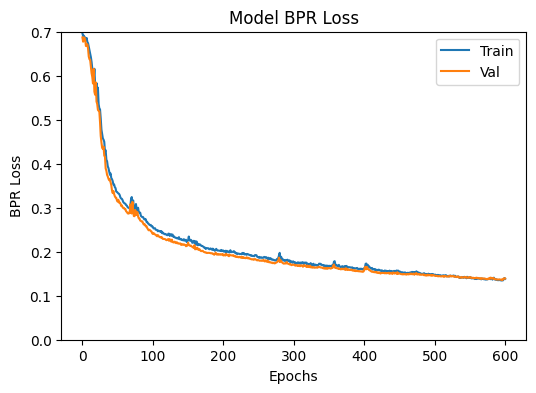

In [339]:
def plot_train_val_loss(stats_dict):
    fig, ax = plt.subplots(1,1, figsize=(6, 4))

    train_loss = stats_dict["train"]["loss"]
    val_loss   = stats_dict["val"]["loss"]

    idx = np.arange(0, len(train_loss), 1)
    ax.plot(idx, train_loss, label="Train")
    ax.plot(idx, val_loss, label="Val")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("BPR Loss")
    ax.set_title("Model BPR Loss")
    ax.set_ylim(0, 0.7)
    ax.legend()
    plt.show()
plot_train_val_loss(sage_stats)

61
61


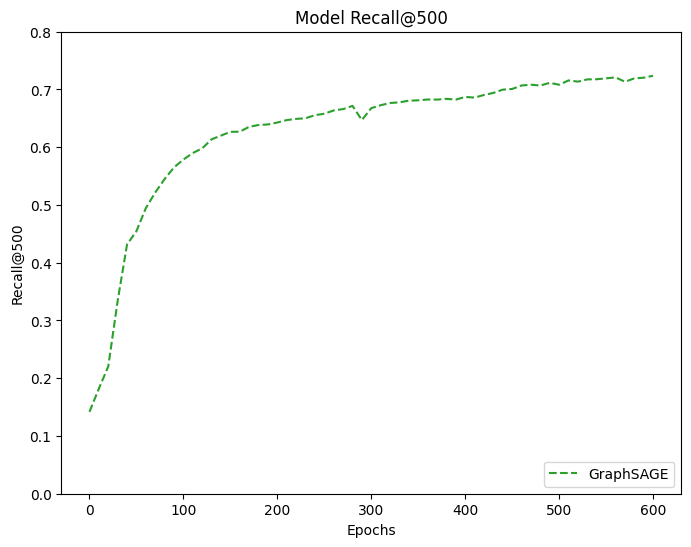

In [332]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
sage_recall = sage_stats["val"][key]

idx = np.arange(0, 10 * len(sage_recall), 10)
print(len(sage_recall))
print(len(idx))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax.plot(idx, sage_recall, color = colors[2], linestyle = 'dashed', label = "GraphSAGE")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@500")
ax.set_title("Model Recall@500")
ax.set_ylim(0, 0.8)
plt.show()